## 3. NMF进行聚类

### 3.1 定义NMF函数

In [3]:
import numpy as np

def nmf(M, n_components, max_iter=10000, tol=1e3, threshold=1):
    W = np.random.rand(M.shape[0], n_components)
    H = np.random.rand(n_components, M.shape[1])
    pre_error = 0

    for i in range(max_iter):
        # 更新矩阵 H
        H *= np.dot(W.T, M) / np.dot(np.dot(W.T, W), H)

        # 更新矩阵 W
        W *= np.dot(M, H.T) / np.dot(np.dot(W, H), H.T)

        # 计算误差
        error = np.linalg.norm(M - np.dot(W, H), 'fro') ** 2
        # print(f"{i}:",error)

        # 检查停止条件
        if error < tol or abs(error - pre_error) < threshold:
            break

        pre_error = error

    return W, H

### 3.2 使用NMF对脑电数据进行降维

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# 读取脑电数据集
dataset = pd.read_csv('./dataset/waveform-5000.csv')

# 提取前40列为特征，最后一列为label
features = dataset.iloc[:, :40].values
labels = dataset.iloc[:, 40].values
print(f"feateures shape:{features.shape}")
print(f"labels shape:{labels.shape}")

# 进行 Min-Max 归一化
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# 使用 NMF 进行聚类，指定成分数为3
n_components = 3
np.random.seed(42)
W, H = nmf(scaled_features, n_components, max_iter=1000)

print(f"W shape:{W.shape}")
print(f"H shape:{H.shape}")

feateures shape:(5000, 40)
labels shape:(5000,)
W shape:(5000, 3)
H shape:(3, 40)


### 3.3 手肘法搜索最佳的聚类数

Number of k-clusters:3


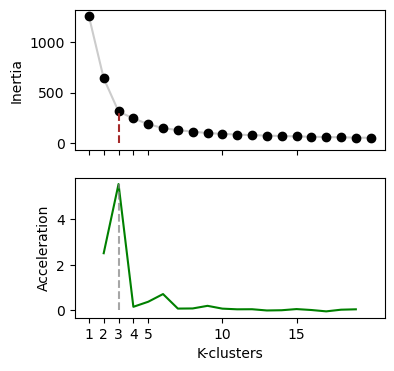

In [5]:
from sklearn.cluster import KMeans

inertia = list() # sum of squared error

for k in range(1,21):
    km = KMeans(n_clusters=k, init='k-means++', random_state = 42)
    km = km.fit(W)
    inertia.append(km.inertia_)

idx = np.arange(1, len(inertia) + 1)

fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

ax[0].plot(idx, inertia, '-', color='gray', alpha = 0.4)
ax[0].plot(idx, inertia, 'ko', ms=6)
ax[0].set_xticks([1,2,3,4,5, 10, 15])

ax[0].set_ylabel('Inertia');

acceleration = np.diff(np.sqrt(inertia), 2)  # 2nd derivative of the distances

ax[1].plot(idx[:-2] + 1, acceleration, 'g-', ms=8)
ax[1].set_ylabel('Acceleration')
ax[1].set_xlabel('K-clusters')

# calculate clusters
k = acceleration.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
ax[0].vlines(x = k, ymin = 0, ymax = inertia[k-1], color='brown', linestyle='--')
ax[1].vlines(x = k, ymin = 0, ymax = acceleration[k-2], color='gray', linestyle='--', alpha=0.7)

print(f'Number of k-clusters:{k}')

### 3.4 绘制前两个主成分维度下的聚类结果

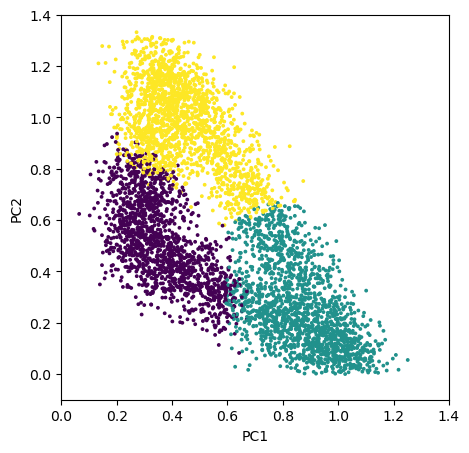

In [20]:
from sklearn.cluster import KMeans

# K-Means, set cluster=3
model = KMeans(n_clusters=3, init='k-means++', random_state = 42)
model.fit(W)
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(x = W[:, 0], y = W[:, 1], s=3, c=model.labels_)
ax.set_xlabel(f'PC1')
ax.set_ylabel(f'PC2')
ax.set_xlim(0,1.4), ax.set_ylim(-0.1,1.4)
ax.set_xticks([i/5 for i in range(8)])
ax.set_yticks([i/5 for i in range(8)])
fig.savefig('./result/q3/cluster_result.png', dpi=500)

### 3.5 输出聚类模型的轮廓系数

In [5]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(W, model.labels_)
print("轮廓系数:", silhouette_avg)

轮廓系数: 0.5072529223377125


### 3.6 与数据集原始label进行对比，查看聚类的指标

In [21]:
# 由于聚类后标签可能会与原来的顺序不一致，如原来是0,1,2聚类后变成了2,1,0
# 因此这里需要遍历各种标签的组合，将准确率最大的一种标签组合作为预测结果，与原标签进行对比

mapping = {0: 'a', 1: 'b', 2: 'c'}
re_mapping = {'a': 0, 'b': 1, 'c': 2}
alpha_labels = [mapping[item] for item in model.labels_]

order = [[0, 1, 2], [0, 2, 1], [1, 2, 0], [1, 0 ,2], [2, 1, 0], [2, 0, 1]]

all_re_labels, acc_lst = [], []
for i in range(len(order)):
    cur_map = order[i]
    re_mapping['a'] = cur_map[0]
    re_mapping['b'] = cur_map[1]
    re_mapping['c'] = cur_map[2]
    re_labels = [re_mapping[item] for item in alpha_labels]
    all_re_labels.append(re_labels)
    print(f"\nre_label[{i}]:")

    # 计算混淆矩阵
    confusion_mat = confusion_matrix(labels, re_labels)

    # 输出正确率和召回率
    accuracy = np.diag(confusion_mat).sum() / confusion_mat.sum()
    acc_lst.append(accuracy)
    print('Accuracy:', accuracy)

max_order_id = np.argmax(acc_lst)
max_labels = all_re_labels[max_order_id]
# print(f"\n准确率最大的id: {max_order_id}\n")

report = classification_report(labels, max_labels)
print(f"\n{report}")



re_label[0]:
Accuracy: 0.0006

re_label[1]:
Accuracy: 0.361

re_label[2]:
Accuracy: 0.5074

re_label[3]:
Accuracy: 0.312

re_label[4]:
Accuracy: 0.327

re_label[5]:
Accuracy: 0.492

              precision    recall  f1-score   support

           0       0.49      0.52      0.51      1692
           1       0.50      0.46      0.48      1653
           2       0.53      0.55      0.54      1655

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000

